## Exact type I error of low N binomials

For the Berry problem, there are only 36^4 possible datasets. As part of the INLA --> table construction, we enumerate which of these datasets result in a rejection. But, we can actually take this enumeration a step further and calculate the binomial mass function for each dataset given a particular set of true theta parameters. Then, we can just multiply this mass by the precomputed binary rejection.

It turns out that for the 4D Berry problem, this is about the same runtime per grid point as doing 10,000 simulations while reducing error to zero. So, uh… that’s great!

It’s, of course, equally straightforward to exactly compute the score/gradient.

I don’t really know how useful these facts are in the long term given that many many problems will not be exactly enumerable like this, but I think it’s another handy tool to have in our toolbox.

In [1]:
import berrylib.util as util
util.setup_nb()

In [2]:
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import numpy as np
import pykevlar.grid as grid
import berrylib.fast_inla as fast_inla
import berrylib.binomial as binomial

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
n_arms = 4
fi = fast_inla.FastINLA(4)
n_arm_samples = 35
seed = 10
n_theta_1d = 16
sim_size = 1000

# define null hypos
null_hypos = []
for i in range(n_arms):
    n = np.zeros(n_arms)
    # null is:
    # theta_i <= logit(0.1)
    # the normal should point towards the negative direction. but that also
    # means we need to negate the logit(0.1) offset
    n[i] = -1
    null_hypos.append(grid.HyperPlane(n, -logit(0.1)))

gr = grid.make_cartesian_grid_range(n_theta_1d, np.full(n_arms, -3.5), np.full(n_arms, 1.0), sim_size)

Red dots are points in the alternative hypothesis space.
Blue dots are points in the null space.

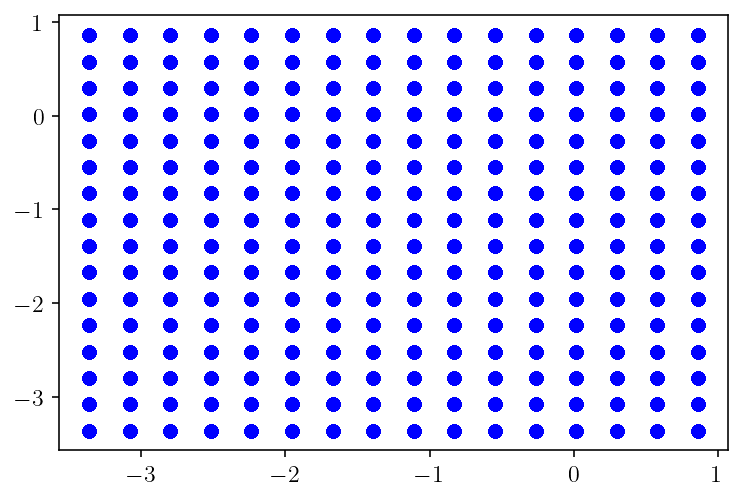

In [4]:
gr.create_tiles(null_hypos)
plt.plot(gr.thetas()[0,:], gr.thetas()[1,:], 'ro')
gr.prune()
plt.plot(gr.thetas()[0,:], gr.thetas()[1,:], 'bo')
plt.show()

In [5]:
accumulator = binomial.binomial_accumulator(fi.rejection_inference)
theta = gr.thetas().T
theta_tiles = grid.theta_tiles(gr)
is_null_per_arm = grid.is_null_per_arm(gr)

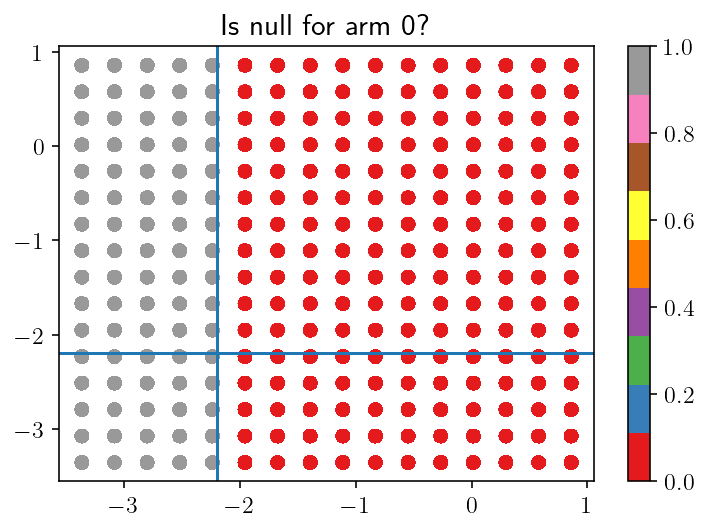

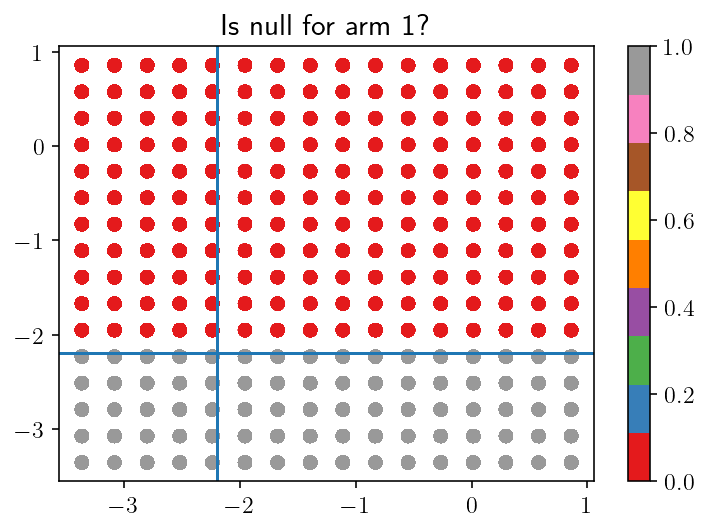

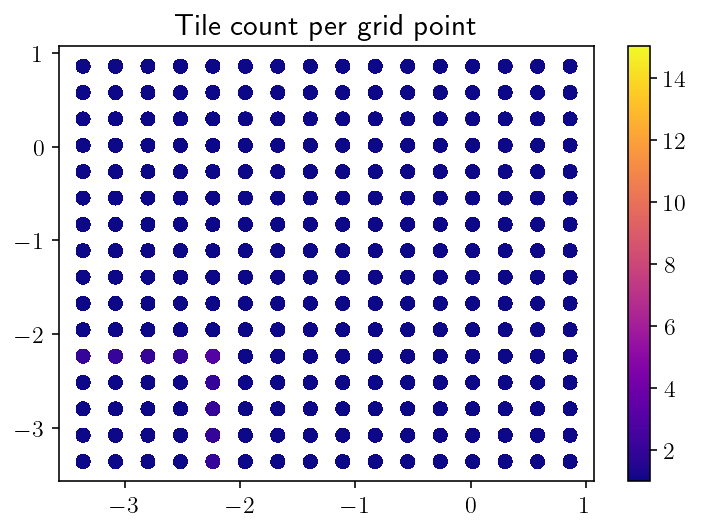

In [6]:
n_tiles_per_pt = grid.n_tiles_per_pt(gr)
pos_start = gr.cum_n_tiles()[:-1]
is_null_per_arm_gridpt = np.add.reduceat(is_null_per_arm, pos_start, axis=0) > 0

plt.title('Is null for arm 0?')
plt.scatter(theta[:,0], theta[:,1], c=is_null_per_arm_gridpt[:,0], cmap='Set1')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()

plt.title('Is null for arm 1?')
plt.scatter(theta[:,0], theta[:,1], c=is_null_per_arm_gridpt[:,1], cmap='Set1')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()

plt.title('Tile count per grid point')
plt.scatter(theta[:,0], theta[:,1], c=n_tiles_per_pt)
plt.colorbar()
plt.show()

In [7]:
%%time
rejection_table = binomial.build_rejection_table(n_arms, n_arm_samples, fi.rejection_inference)
np.random.seed(10)

CPU times: user 4.44 s, sys: 315 ms, total: 4.76 s
Wall time: 3.39 s


In [8]:

%%time
typeI_sum = np.zeros(theta_tiles.shape[0])
typeI_score = np.zeros(theta_tiles.shape)
accumulator = binomial.binomial_accumulator(lambda y,n: binomial.lookup_rejection(rejection_table, y))
for i in range(sim_size):
    samples = np.random.uniform(0, 1, size=(1, n_arm_samples, fi.n_arms))
    chunk_typeI_sum, chunk_typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)
    typeI_sum += chunk_typeI_sum
    typeI_score += chunk_typeI_score

CPU times: user 8.09 s, sys: 6.2 s, total: 14.3 s
Wall time: 4.85 s


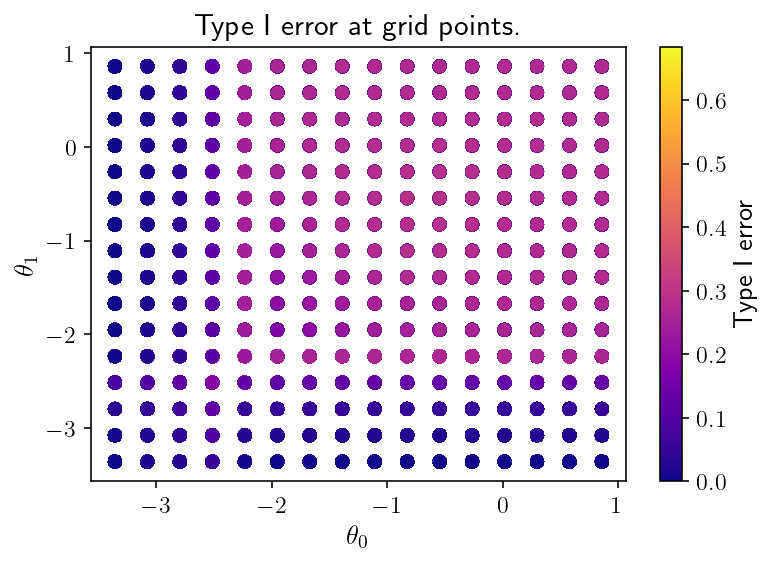

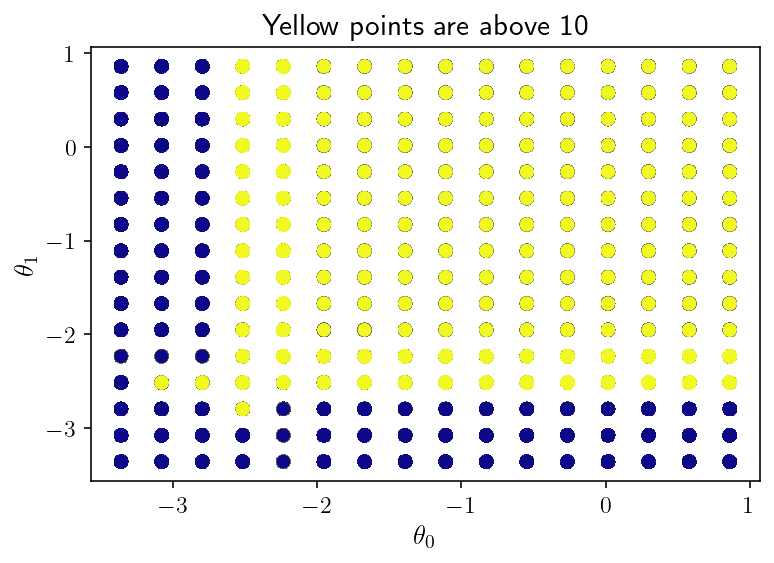

In [9]:
plt.figure()
plt.title('Type I error at grid points.')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=typeI_sum / sim_size)
cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()
plt.title('Yellow points are above 10%')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=typeI_sum / sim_size > 0.1)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.show()

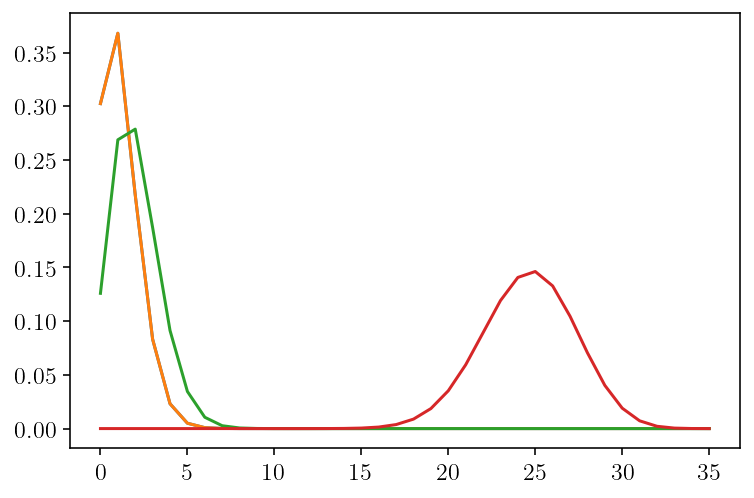

In [10]:
import scipy.stats
ys = np.arange(n_arm_samples + 1)
p_tiles = expit(theta_tiles[50,:])
pmf = scipy.stats.binom.pmf(ys[:, None], n_arm_samples, p_tiles[None, :])
plt.plot(ys, pmf)
plt.show()

In [11]:
pmf.shape

(36, 4)

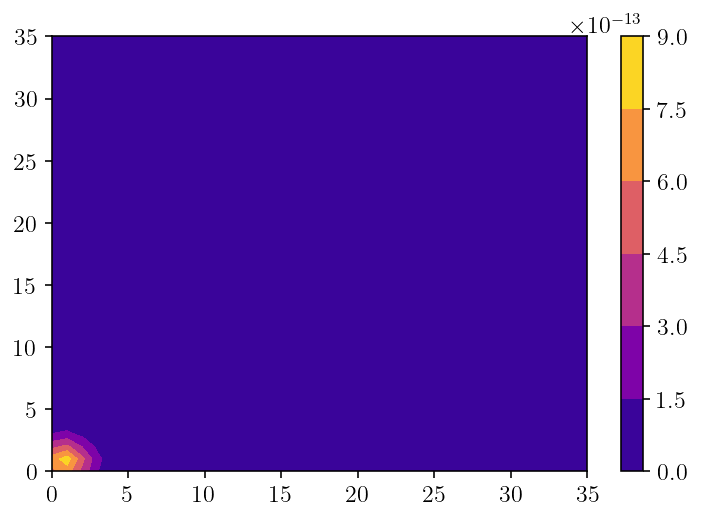

In [12]:
prod_pmf = np.prod(np.meshgrid(*[pmf[:,i] for i in range(n_arms)], indexing='ij'), axis=0)
Y1, Y2 = np.meshgrid(ys, ys, indexing='ij')
plt.contourf(Y1, Y2, prod_pmf[:,:,10,10])
plt.colorbar()
plt.show()

In [13]:
prod_pmf.sum()

1.0000000000000004

In [14]:
theta_tiles.shape

(62785, 4)

In [15]:
%%time
p_tiles = expit(theta_tiles)
pmf = scipy.stats.binom.pmf(ys[:, None, None], n_arm_samples, p_tiles[None, :, :])

typeI_rate = np.empty(theta_tiles.shape[0])
for tile_idx in range(100):#theta_tiles.shape[0]):
    if tile_idx % 20 == 0:
        print(tile_idx)
    prod_pmf = np.prod(np.meshgrid(*[pmf[:,tile_idx,i] for i in range(4)], indexing='ij'), axis=0)
    typeI_lookup = np.any(rejection_table.to_py() & is_null_per_arm[tile_idx], axis=1)
    typeI_rate[tile_idx] = (prod_pmf.ravel() * typeI_lookup).sum()

0
20
40
60
80
CPU times: user 3.69 s, sys: 877 ms, total: 4.57 s
Wall time: 4.56 s


In [36]:
import jax.numpy as jnp
import jax
def jax_typeI_rate(pmf, is_null):
    prod_pmf = (pmf[:, None, None, None, 0]
    * pmf[None, :, None, None, 1]
    * pmf[None, None, :, None, 2]
    * pmf[None, None, None, :, 3]).ravel()
    # prod_pmf = jnp.prod(jnp.array(jnp.meshgrid(*[pmf[:,i] for i in range(4)], indexing='ij')), axis=0).ravel()
    typeI_lookup = jnp.any(rejection_table & is_null, axis=1)
    return (prod_pmf * typeI_lookup).sum()
jax_typeI_rates = jax.jit(jax.vmap(jax_typeI_rate, in_axes=(1, 0)))

In [37]:
rejection_table.shape

(1679616, 4)

In [38]:
theta_tiles.shape[0]

62785

In [41]:
%%time
rates = np.empty(theta_tiles.shape[0])
chunk_size = 2000
for i in range(theta_tiles.shape[0] // chunk_size + 1):
    print(i)
    start = i * chunk_size
    end = (i + 1) * chunk_size
    if end > theta_tiles.shape[0]:
        end = theta_tiles.shape[0]
    rates[start:end] = jax_typeI_rates(pmf[:, start:end], is_null_per_arm[start:end])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
CPU times: user 4min 59s, sys: 2min 5s, total: 7min 4s
Wall time: 1min 9s


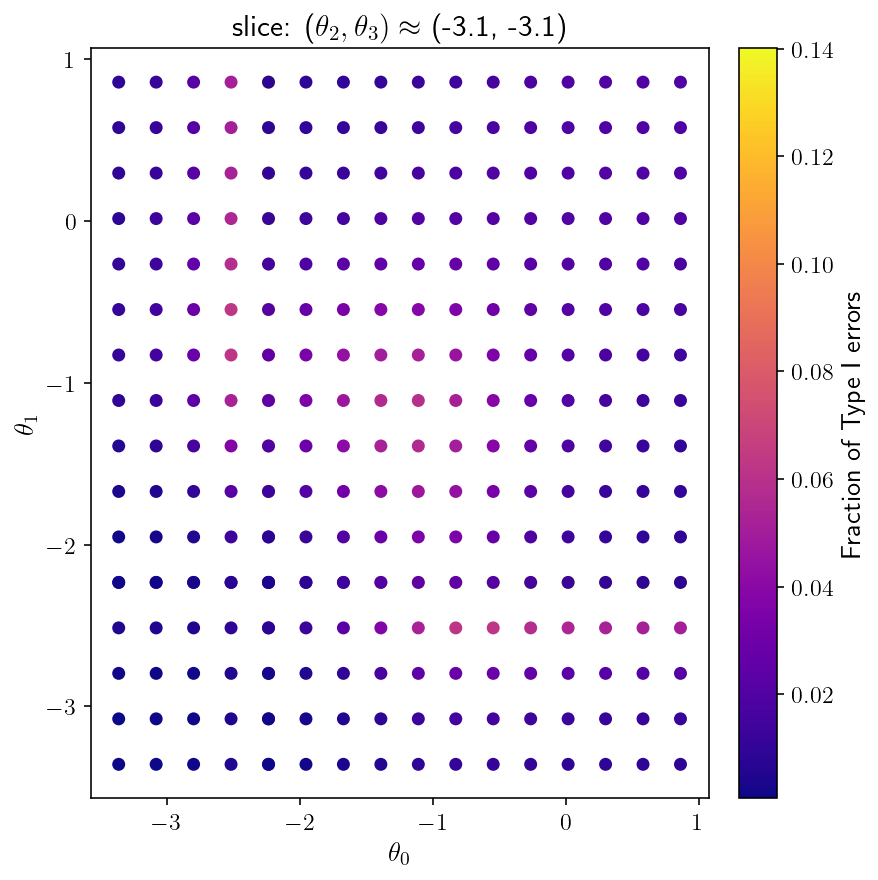

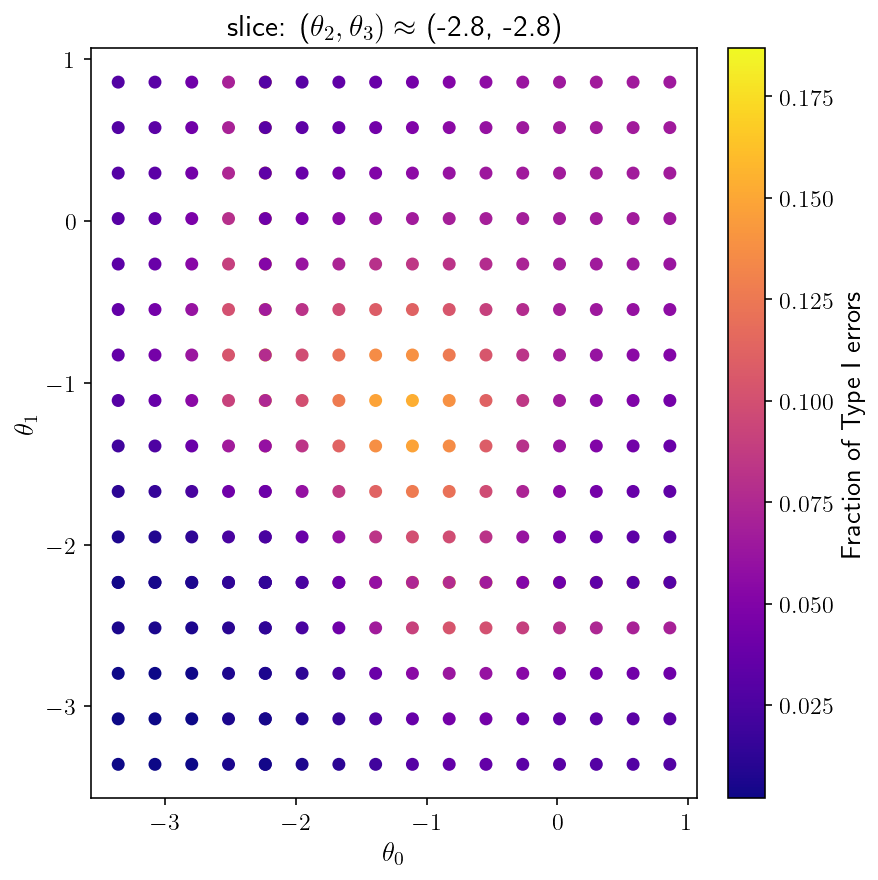

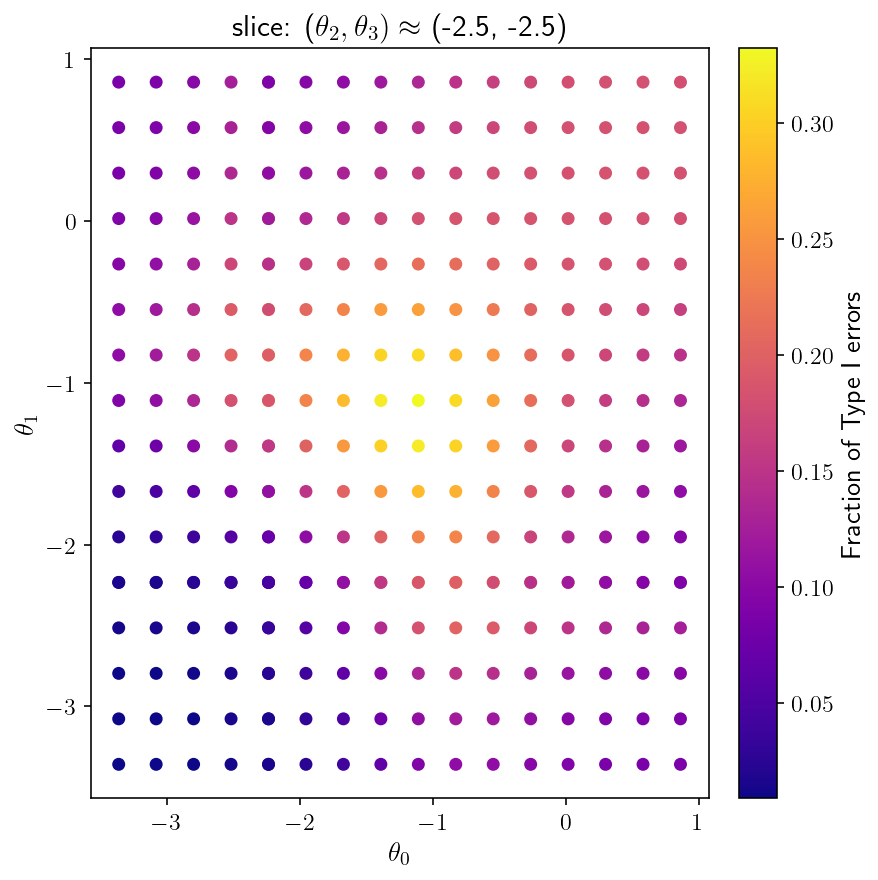

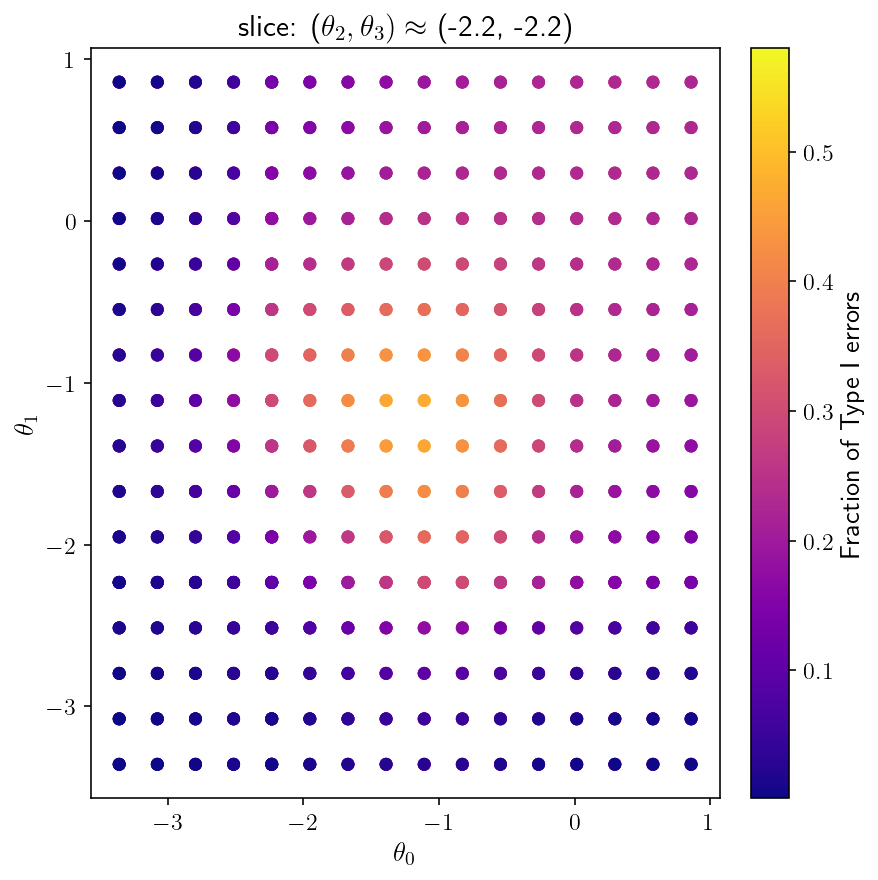

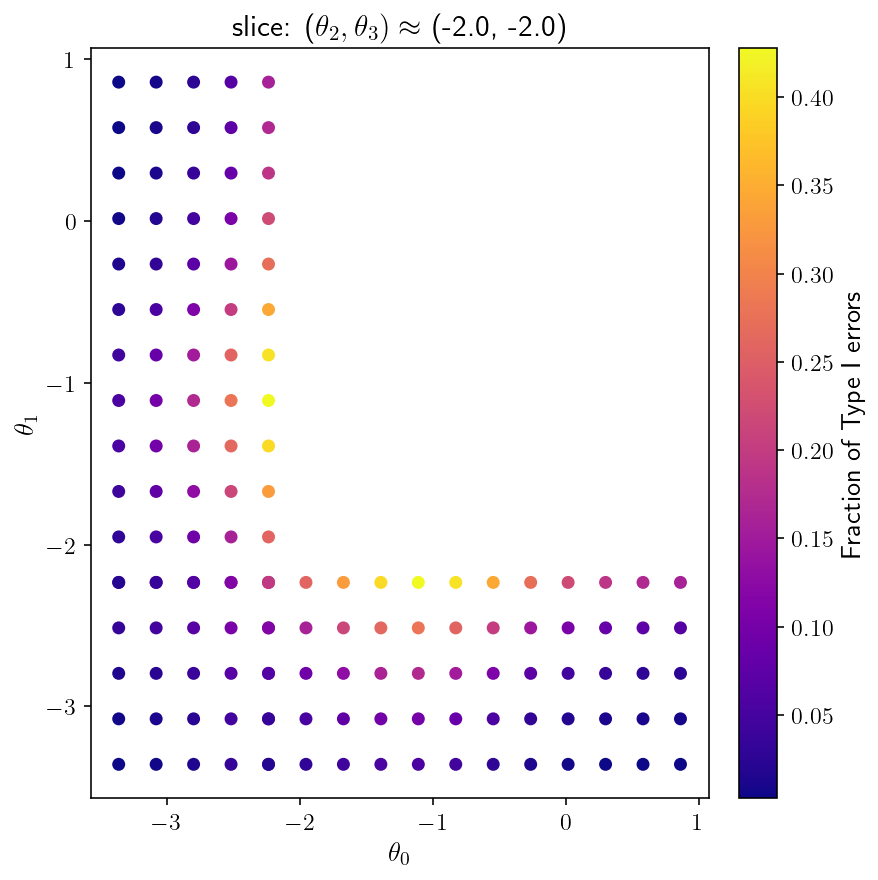

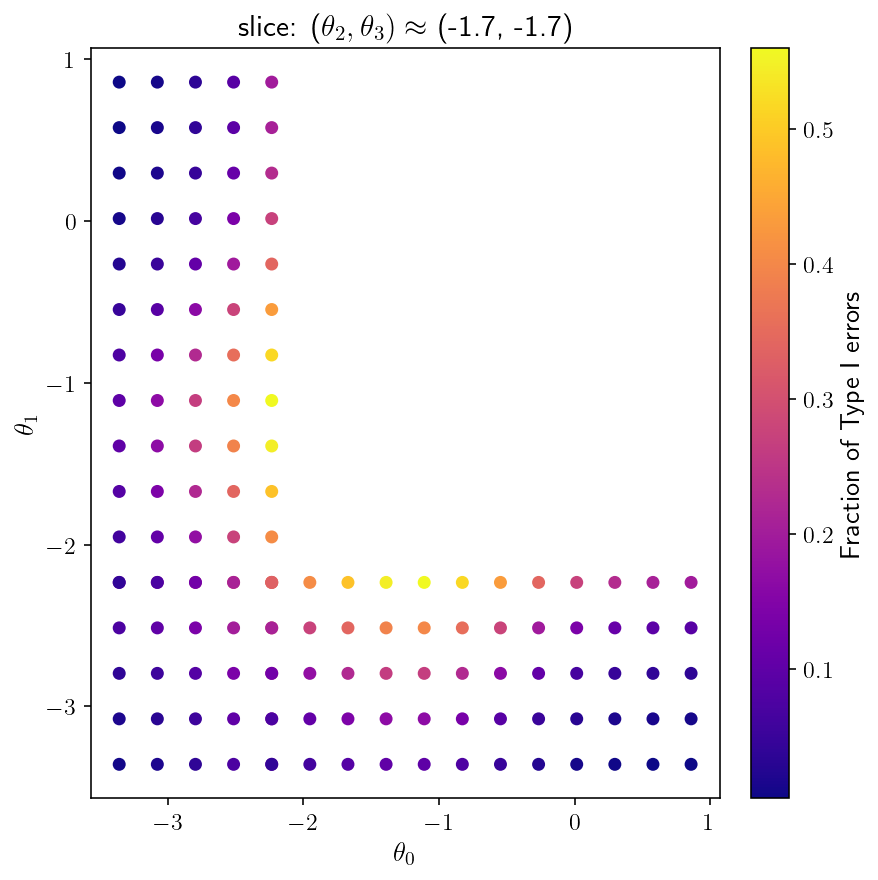

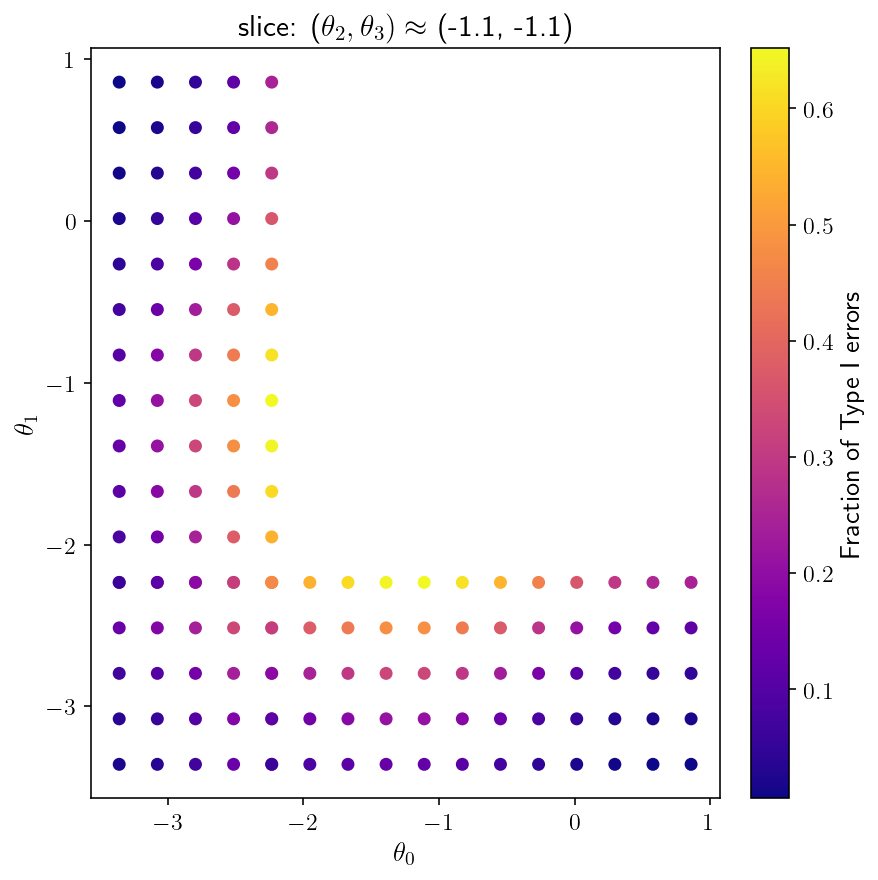

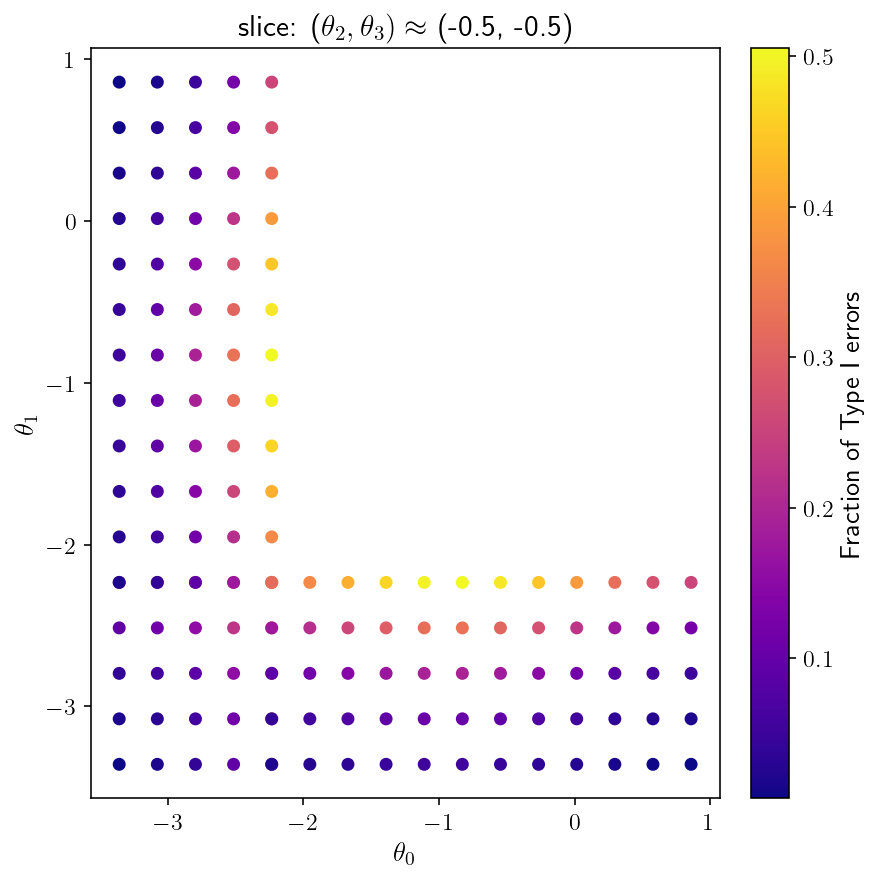

In [42]:
for t2_idx, t3_idx in [(1,1), (2,2), (3,3), (4, 4), (5,5), (6,6), (8, 8), (10,10)]:
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    t3 = np.unique(theta_tiles[:, 2])[t3_idx]
    selection = (theta_tiles[:,2] == t2) & (theta_tiles[:,3] == t3)

    plt.figure(figsize=(6,6), constrained_layout=True)
    plt.title(f'slice: ($\\theta_2, \\theta_3) \\approx$ ({t2:.1f}, {t3:.1f})')
    plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=rates[selection], s=30)
    cbar = plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    cbar.set_label('Fraction of Type I errors')
    plt.show()